In [22]:
# For running inference on the TF-Hub module.
import tensorflow as tf

# import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.3.0
The following GPU devices are available: 


In [76]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [26]:
# https://i.pinimg.com/originals/07/06/e2/0706e2d368eb7344bfca507cbf3af7db.jpg
image_url = "https://i.pinimg.com/originals/07/06/e2/0706e2d368eb7344bfca507cbf3af7db.jpg"
downloaded_image_path = download_and_resize_image(image_url, 299, 299, True)

Image downloaded to C:\Python310\Lib\site-packages\tmpfw8s4qwv.jpg.


C:\Python310\Lib\site-packages\ipykernel_12084\1338668134.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


In [25]:
tmp = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

ValueError: If using `weights` as `"imagenet"` with `include_top` as true, `classes` should be 1000

In [11]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [12]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  print(type(result))
#   ans.append(result)
  # print(ans)
  display_image(image_with_boxes)

In [27]:
img = load_img(downloaded_image_path)

converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
start_time = time.time()
result = tmp(converted_img)
# result = model(converted_img)
end_time = time.time()

# result = {key:value.numpy() for key,value in result.items()}

# print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

Inference time:  0.9143202304840088


In [28]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [29]:
import pandas as pd
DF = pd.DataFrame(imagenet_labels)
# save the dataframe as a csv file
DF.to_csv("data1.csv")

In [30]:
decoded = imagenet_labels[np.argsort(result)[0,::-1][:5]+1]

In [31]:
decoded

array(['patio', 'restaurant', 'lakeside', 'park bench', 'library'],
      dtype='<U30')

In [21]:
saved_model_dir = 'model.h5'
tmp.save(saved_model_dir)
print("Model Saved to model.h5")

Model Saved to model.h5


In [32]:
# from keras.models import load_model
# model = load_model('model.h5')

In [69]:

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

C:\Python310\Lib\site-packages\ipykernel_12084\1075473974.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to C:\Python310\Lib\site-packages\tmp21suflfk.jpg.


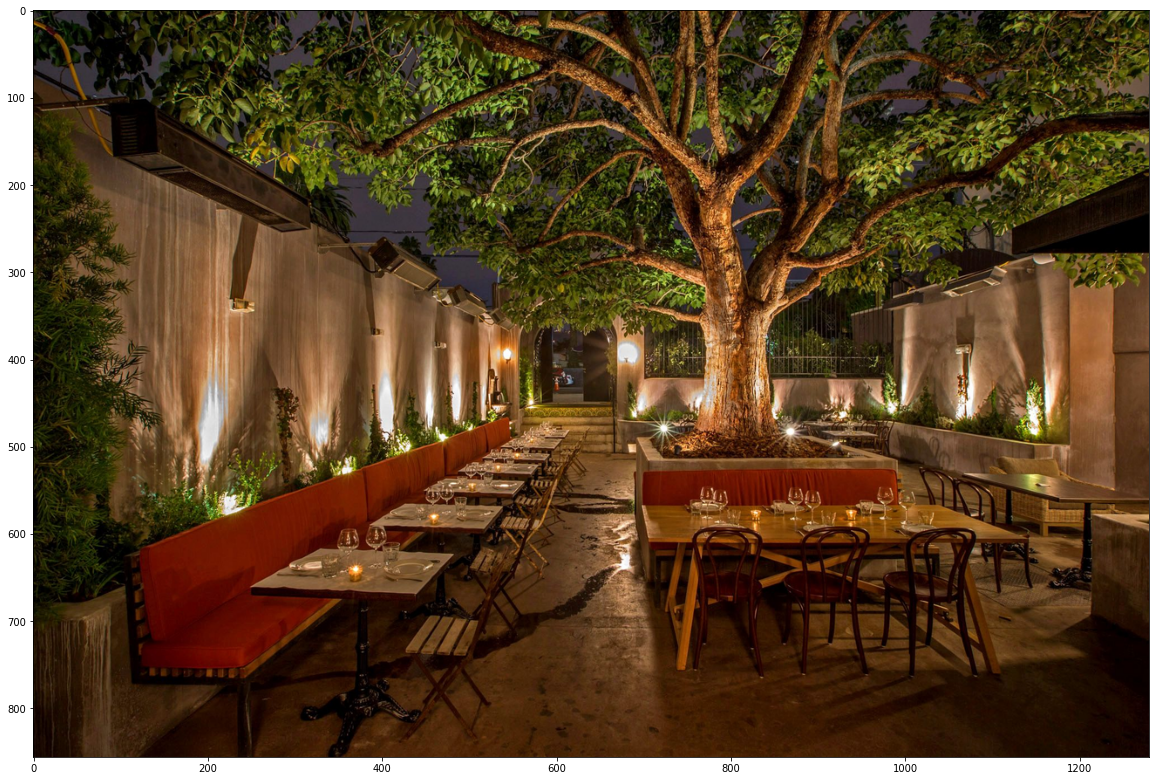

In [77]:
image_url = "https://i.pinimg.com/originals/07/06/e2/0706e2d368eb7344bfca507cbf3af7db.jpg"
# image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [78]:
# !pip list

In [79]:
# !pip install "tensorflow>=2.0.0" --user

In [80]:
# !pip install --upgrade tensorflow-hub

In [74]:
import tensorflow_hub as hub

In [75]:
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [84]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [85]:
ans = []

In [86]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  print(type(result))
  ans.append(result)
  # print(ans)
  display_image(image_with_boxes)

Found 100 objects.
Inference time:  9.129920959472656
Font not found, using default font.
<class 'dict'>


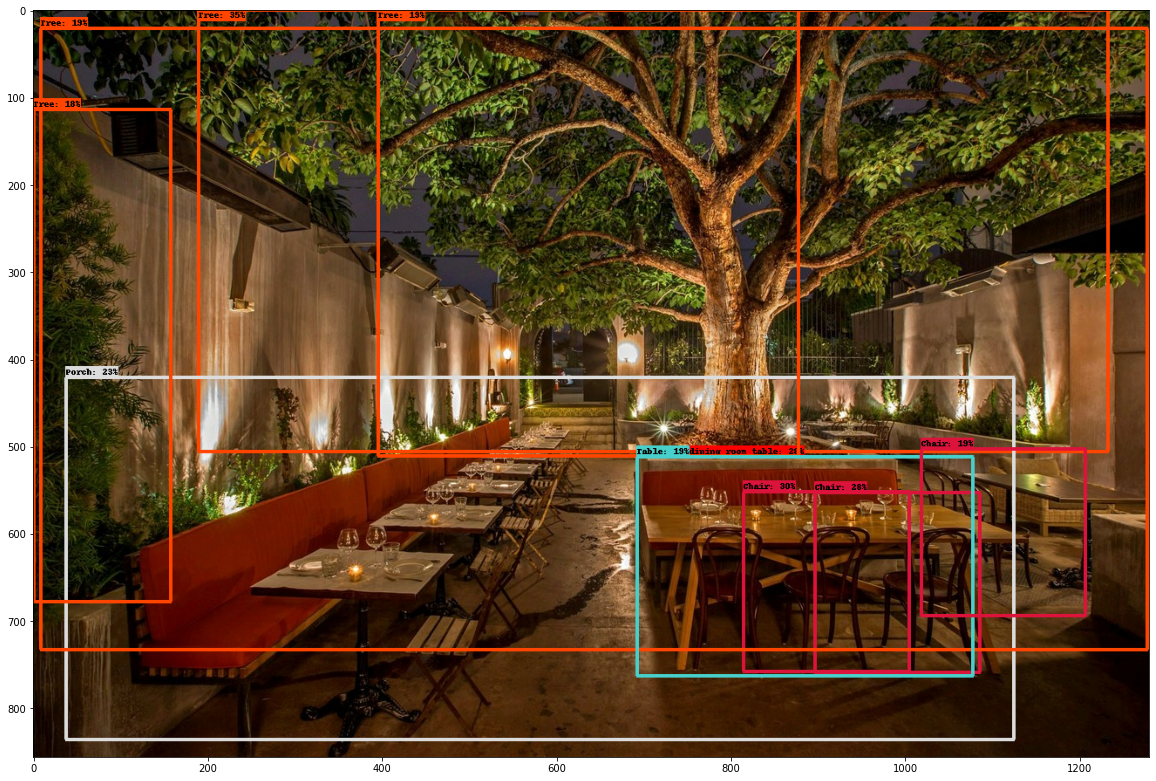

In [87]:
run_detector(detector, downloaded_image_path)

In [91]:
tmp = ans[0]
tmp
arr1 = tmp['detection_class_entities']
arr2 = tmp['detection_scores']
arr3 = arr1[arr2>0.3]
arr3 = arr3.astype('str')
arr3

unique, counts = np.unique(arr3, return_counts=True)
for x in range(0,len(counts)):
  if counts[x]>1:
    print('multiple '+str(unique[x])+'s')
  else:
    print(str(unique[x]))

Chair
Tree


In [89]:
arr2

array([0.35244274, 0.30833703, 0.2871095 , 0.28320563, 0.23158196,
       0.19804415, 0.19517496, 0.19101098, 0.1909096 , 0.18553206,
       0.16511616, 0.16448832, 0.16423124, 0.16106945, 0.15832213,
       0.15652987, 0.15420371, 0.15328082, 0.14817634, 0.14755905,
       0.14298558, 0.14254764, 0.14175597, 0.14156586, 0.14149442,
       0.14112905, 0.13802075, 0.13732198, 0.1364083 , 0.1363047 ,
       0.1361855 , 0.13340646, 0.13268548, 0.12990099, 0.12899497,
       0.12846047, 0.12706324, 0.12632734, 0.1248894 , 0.12442464,
       0.12422019, 0.12388217, 0.12365615, 0.1231083 , 0.12258023,
       0.12142149, 0.12057024, 0.11875567, 0.1176168 , 0.11690307,
       0.11686221, 0.11544955, 0.11517709, 0.11487755, 0.11451373,
       0.11444774, 0.11344314, 0.11337525, 0.11293095, 0.1127941 ,
       0.11255166, 0.11221594, 0.11183128, 0.11164394, 0.11124486,
       0.11100301, 0.11028033, 0.10969871, 0.10932213, 0.10867634,
       0.10851699, 0.10786784, 0.10766405, 0.10709539, 0.10677